In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
# df = pd.read_csv("edd_cf4_refined.csv", sep='|')
df = pd.read_csv("btfr_brent_updated.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df = df.rename(columns={"e_F21":"eF21"})

df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['flag', 'DM_av', 'eDM', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'DM_75',
       '1PGC', 'Nest', 'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel',
       'Vls', 'v3k', 'f', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc',
       'g***', 'r***', 'i***', 'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE',
       'GLong', 'GLat', 'SGL', 'SGB', 'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg',
       'Vlsg', 'V3kg', 'fg'],
      dtype='object')
10153


,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,SGL,SGB,Nkt,N15,SGLg,SGBg,Vhg,Vlsg,V3kg,fg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.11,73150,200275.0,...,341.6440,20.7388,0,7,341.4922,20.7395,5194,5486,4916,1.013
4,1,33.49,0.38,33.44,0.19,33.54,0.19,33.72,120,202766.0,...,316.0587,18.4514,0,0,316.0587,18.4514,4458,4706,4109,1.011
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.61,12,210177.0,...,286.4249,11.3511,0,1,286.4249,11.3510,6532,6669,6179,1.016
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.30,16,211419.0,...,287.6119,11.7030,0,1,287.6120,11.7030,5709,5851,5354,1.014
55,1,33.71,0.43,33.70,0.26,33.71,0.25,33.89,55,NaN,...,327.0996,19.7763,0,0,327.0996,19.7763,4779,5052,4454,1.012


In [4]:
df['Vmod'] = df.Vlsg # df.fg*df.Vlsg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [6]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

,Flux
PGC,
2,4.73
4,1.85
6,NaN
10,2.47
12,3.40


In [7]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"Vls":"V3k"})

df.head()

,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,logD75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,gi,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.320973,73150,200275.0,...,1.864195,NaN,NaN,NaN,NaN,-22.430973,NaN,NaN,NaN,4.73
4,1,33.49,0.38,33.44,0.19,33.54,0.19,33.987953,120,202766.0,...,1.797591,-18.397953,-18.657953,-18.867953,-18.917953,-17.917953,0.47,1.96,0.07,1.85
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.744997,12,210177.0,...,1.948999,NaN,NaN,NaN,NaN,-21.154997,NaN,NaN,NaN,3.40
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.460844,16,211419.0,...,1.892169,-20.100844,-20.600844,-20.880844,-21.060844,-20.470844,0.78,NaN,NaN,1.19
55,1,33.71,0.43,33.70,0.26,33.71,0.25,34.142010,55,NaN,...,1.828402,-18.612010,-18.822010,-18.922010,-18.972010,-17.942010,0.31,NaN,NaN,4.30


In [8]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
dg.loc[adhi_list]['F21_'] = dg.loc[adhi_list].Flux   # using ADHI HI flux values


len(dg)

# df["F21"] = dg.F21_
# df["eF21"] = dg.F21_e

<ipython-input-8-69eae98da3b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-8-69eae98da3b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


10153

In [9]:
new_drop = pd.read_csv("drop_january2021.bar", sep='|')

df = df.drop(new_drop.PGC.values, errors='ignore')

len(df)

10153

In [10]:
calib = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

for col in calib.columns:
    newcol = col.strip()
    calib.rename(columns={col:newcol}, inplace=True)
    
calib_weird = [68535, 28378, 42081, 39461, 44536]
calib['Name']=calib.apply(lambda x: None if x.PGC in calib_weird else x.Name, axis=1)
            
calib.set_index('PGC', inplace=True)

calib = calib.join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi', 'g***', 'r***', 'i***', 'z***']]).dropna()
calib = calib[(calib.Qs>2) & (calib['i']>0)]

calib['Dist'] = 10**((calib.dm19-25)/5.)
calib['Mass_HI'] = 2.356E5 * calib.F21 * (calib.Dist**2)


for waveband in ['g***','r***','i***','z***']:
    calib[waveband] = calib.apply(lambda x: x[waveband] if x[waveband]!=0 else np.nan, axis=1)
for waveband in ['g','r','i','z']:
    calib[waveband+'***'] = calib.apply(lambda x: x[waveband+'***'] if x[waveband]!=0 else np.nan, axis=1)

calib['Mr'] = calib['r***']-calib.dm19
calib['Mi'] = calib['i***']-calib.dm19
calib['Mz'] = calib['z***']-calib.dm19
calib['gi'] = calib["g***"]-calib['i***']


calib['logMs_i']  = 1.619 + 0.510*calib.gi - 0.4*calib['Mi']
calib['logMs_r']  = 1.617 + 0.650*calib.gi - 0.4*calib['Mr']
calib['logMs_z']  = 1.610 + 0.461*calib.gi - 0.4*calib['Mz']


alfa = 0.536
beta = 1.616
calib['logMs_riz'] = beta + alfa*calib.gi - 0.4*calib[["Mr", "Mi", "Mz"]].mean(axis=1)

calib['Ms_riz'] = 10**calib.logMs_riz
calib = calib.dropna()

print(len(calib))
calib.head()

45


,So,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,Mi,...,i***,z***,Dist,Mass_HI,gi,logMs_i,logMs_r,logMs_z,logMs_riz,Ms_riz
PGC,,,,,,,,,,,,,,,,,,,,,
21396,2,NGC2403,27.514,58,2.454,0.026,-18.56,-19.43,-19.704,-19.854,...,7.66,7.64,3.182731,3.273213e+09,0.42,9.7748,9.7716,9.75322,9.765387,5.826217e+09
28357,2,NGC3021,32.327,58,2.454,0.022,-19.11,-20.11,-20.617,-20.897,...,11.43,11.30,29.201153,2.535331e+09,0.79,10.3807,10.3773,10.38499,10.378240,2.389131e+10
32192,2,NGC3368,30.165,52,2.630,0.024,-19.29,-20.67,-21.355,-21.715,...,8.45,8.31,10.789467,2.248998e+09,1.04,10.8354,10.8350,10.83144,10.830107,6.762490e+10
32207,2,NGC3370,32.149,56,2.514,0.021,-19.43,-20.22,-20.589,-20.779,...,11.37,11.30,26.902956,4.424994e+09,0.56,10.2162,10.2166,10.20776,10.211760,1.628396e+10
34695,2,NGC3627,30.125,64,2.605,0.015,-20.04,-21.16,-21.715,-21.985,...,8.14,7.99,10.592537,1.206747e+09,0.82,10.8312,10.8360,10.84202,10.833520,6.815850e+10


In [11]:
# calib.loc[26317].head(20)

In [12]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [13]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

df['logMs_i']  = 1.619 + 0.510*df.gi - 0.4*df['Mi_75']
df['logMs_r']  = 1.617 + 0.650*df.gi - 0.4*df['Mr_75']
df['logMs_z']  = 1.610 + 0.461*df.gi - 0.4*df['Mz_75']

alfa = 0.536
beta = 1.616
df['logMs_riz'] = beta + alfa*df.gi - 0.4*df[["Mr_75", "Mi_75", "Mz_75"]].mean(axis=1)
df['Ms_riz'] = 10**df.logMs_riz

In [14]:
mc = -6.003192164863257e-05
def HI_corrector(mc, bc, V3k):
    return 0 # mc*V3k+bc

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


iter:  0
iter:  1
3.1137439646812597 10.472430176786546


<ipython-input-15-ec6528dcd71f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.
<ipython-input-15-ec6528dcd71f>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-15-ec6528dcd71f>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

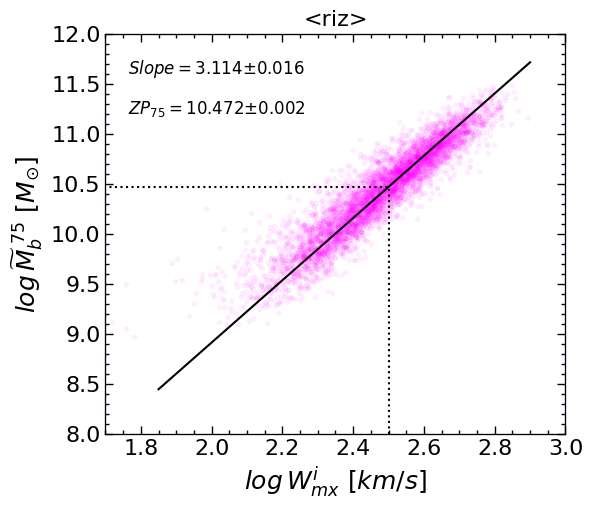

In [15]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.5*std]

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    V3k = dff.V3k.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21.values * (dff.D75.values**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    Mb = dff.Ms_riz.values + 1.33*(10**(np.log10(dff.Mass_HI.values)))
    dlogMb = dMb/Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
    
    fit, cov = np.polyfit(logW-2.5, logMass, 1, w=1./(m*logWe), cov=True)
    m = fit[0]
    b = fit[1]
    
#     if jj>0:
#         mcfit = lts_linefit(logW-2.5, logMass, np.sqrt(logWe**2+(0.01)**2), 0.*dlogMb+0.01, clip=3.)    

    dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)
    
logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass, '.', color='magenta', alpha=0.05) 


w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'k-')
print(m0,b0)    
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{\/\/75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.9*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.8*Ylm[1]
ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')

ax.plot([2.5,2.5], [8, b0], 'k:')
ax.plot([0,2.5], [b0, b0], 'k:')

3.1137439646812597 10.472430176786546


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-16-ae4eb3f069c6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


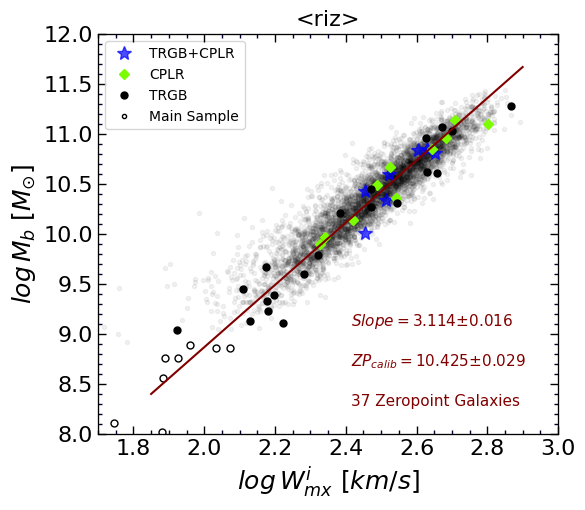

In [16]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

calib['Mb'] = calib.Ms_riz + 1.33*(10**(np.log10(calib.Mass_HI)+HI_corrector(mc, 0, calib.V3k.values)))
calib['logMb'] = np.log10(calib.Mb.values)


dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

   

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################
def linear_zp(x, zp):
    
    return x/m0+zp

X = calib.lgWmxi.values
Xe = calib.elgWi.values
Y = calib.logMb.values
BB = calib['logMb']
So = calib.So.values

fit, cov = curve_fit(linear_zp, Y[BB>9], X[BB>9]-2.5, sigma=np.sqrt(Xe[BB>9]**2+(0.01)**2))
zp_calib = -fit[0]*m0
zp_calib_e = np.sqrt(cov[0][0])*m0

zp_calib_e = np.sqrt(zp_calib_e**2+db0**2)

zp_calib += 0.044


logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass-b0+zp_calib, '.', color='k', alpha=0.05) 

ind, = np.where((BB<9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', mfc='white') 
ind, = np.where((BB>9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', alpha=0.7, label='TRGB+CPLR') 


ind, = np.where((BB<9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', mfc='white') 
ind, = np.where((BB>9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', alpha=1.0, label='CPLR') 


ind, = np.where((BB<9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', mfc='white') 
ind, = np.where((BB>9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', label='TRGB') 

ax.plot([0], [0], '.', color='k', label='Main Sample', mfc='white') 
#######################################################################

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, '-', color='maroon')
print(m0,b0)    

    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$log \/ M_b \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.95*Xlm[0]+0.05*Xlm[1]
# y0 = 0.1*Ylm[0]+0.9*Ylm[1]
# ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
# y0 = 0.2*Ylm[0]+0.8*Ylm[1]
# ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.45*Xlm[0]+0.55*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, "%d"%len(Xe[BB>9])+' Zeropoint Galaxies', fontsize=11, color='maroon')
y0 = 0.83*Ylm[0]+0.17*Ylm[1]
ax.text(x0,y0, r"$ZP_{calib} = $"+"%.3f" % zp_calib+'$\pm$'+"%.3f" % zp_calib_e, fontsize=11, color='maroon')
y0 = 0.73*Ylm[0]+0.27*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=11, color='maroon')

ax.legend(loc=2)

In [17]:
np.std(Y[(Y<11.5)&(Y>9.0)] - (m0*(X[(Y<11.5)&(Y>9.0)]-2.5) + zp_calib))

0.1809374156902651

In [18]:
std

10000000000.0

In [19]:
b0 = zp_calib
b0

10.425313763684564

718
758
53


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-20-aec63deee2d3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


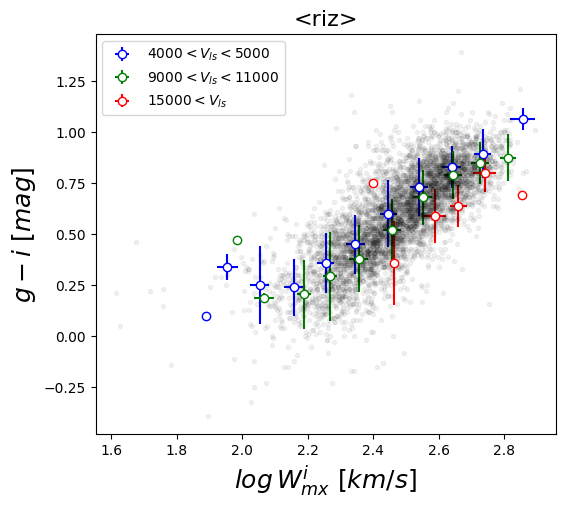

In [20]:
df['Mb0'] =  1.33*(10**(np.log10(df.Mass_HI)))
# df['logMb0'] = np.logD75 # np.log10(df.Mb0.values)

df['Vmod'] = df.Vlsg # df.fg*df.Vlsg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.gi.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{ls}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{ls}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{ls}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$g-i \/\/ [mag]$', fontsize=18)
# set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

ax.legend()

# ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-21-37cde12d31d3>:2: RuntimeWarning: divide by zero encountered in log10
  df['logMb0'] = np.log10(df.Mb0.values)
<ipython-input-21-37cde12d31d3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


718
758
53


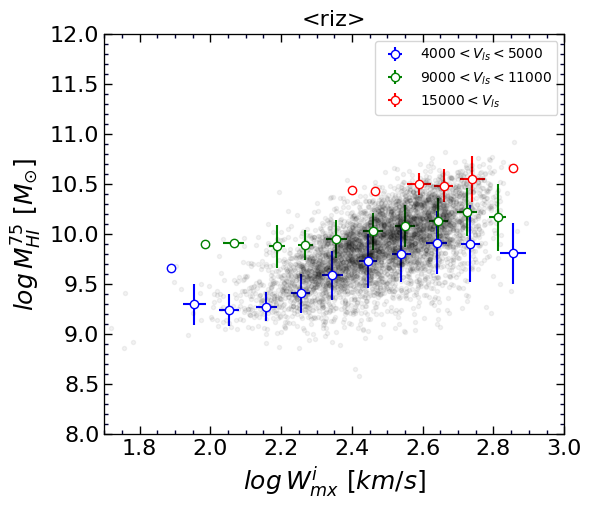

In [21]:
df['Mb0'] =  1.33*(10**(np.log10(df.Mass_HI)))
df['logMb0'] = np.log10(df.Mb0.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb0.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{ls}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{ls}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{ls}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_{HI}^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

ax.legend()

# ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

<ipython-input-22-a0d5afec4746>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


718
758
53


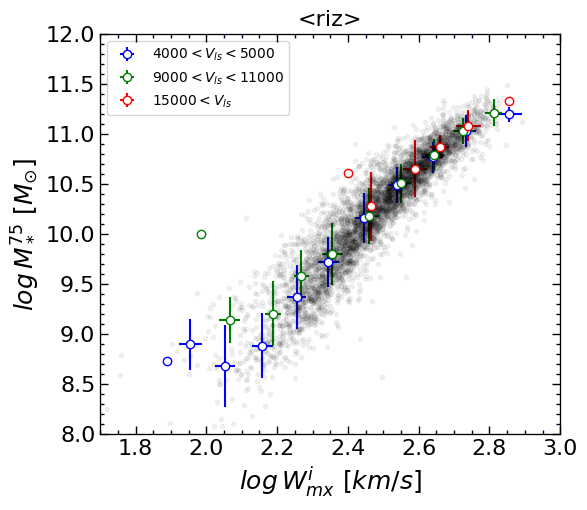

In [22]:
df['Mb0'] = df.Ms_riz # + 1.33*(10**(np.log10(df.Mass_HI)))
df['logMb0'] = np.log10(df.Mb0.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb0.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{ls}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{ls}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{ls}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_*^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

ax.legend()

# ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-23-31b87acd8410>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


718
758
53


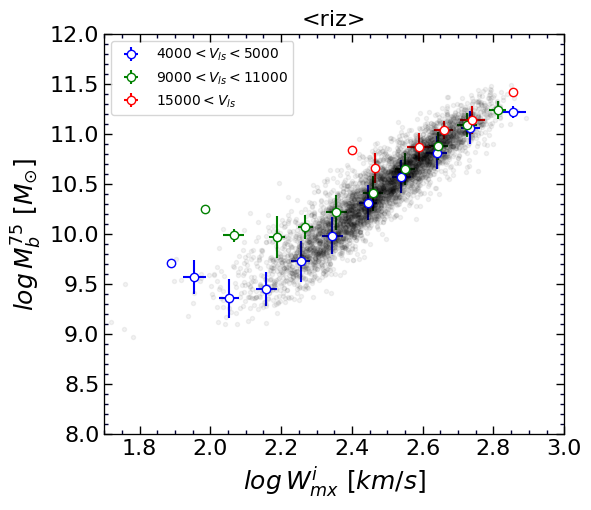

In [23]:
df['Mb0'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)))
df['logMb0'] = np.log10(df.Mb0.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb0.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{ls}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{ls}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{ls}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz>", fontsize=16)

ax.legend()

# ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-24-69c06ad1120b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


718
758
53


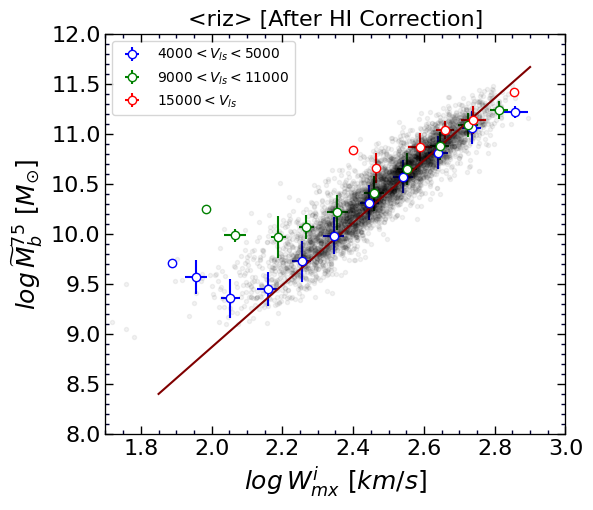

In [24]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{ls}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{ls}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{ls}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz> [After HI Correction]", fontsize=16)

ax.legend()

ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

In [25]:
m0, b0, alfa, beta

(3.1137439646812597, 10.425313763684564, 0.536, 1.616)

In [26]:
def getDM(mag_r, mag_i, mag_z, Wlog, F21, m0, b0, D, gi, V3k):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
        
    alfa = 0.536
    beta = 1.616
    logXriz = beta + alfa*gi
    
    Mag_riz = -2.5*(np.log10(Mb - 1.33*M21) - logXriz)
    
    if mag_r>0 and mag_i>0 and mag_z>0:
        DM = np.nanmean([mag_r , mag_i , mag_z]) - Mag_riz
    else:
        return np.nan

    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [27]:
def getDM_simul(D, mag_r, mag_i, mag_z, gi, Wlog, F21, alfa, beta, MtoLscatter, slope, zp, V3k, mc):
    
    Mb = 10**(slope*(Wlog-2.5)+zp)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + mc*V3k)
    
    logX = beta + alfa*gi   
    Mag  = -2.5*(np.log10(Mb - 1.33*M21) - logX)
    
    if mag_r>0 and mag_i>0 and mag_z>0:
        mag = (mag_r+mag_i+mag_z)/3.
    else:
        return D*0. + np.nan
       
    DM = mag - Mag
    D = 10**((DM-25)/5)
    
    return D

npzName = "MLratio_riz_gi.npz"
npzfile = np.load(npzName)
samples_ = npzfile['arr_0']
samples_ = samples_[np.where(samples_[:,0]>0)]
samples_ = samples_[(samples_[:,1]>1.56)&(samples_[:,1]<2)]
samples_ = samples_[np.where(samples_[:,3]>10.25)]

alfaPool = samples_[:,0]
betaPool = samples_[:,1]
slopePool = samples_[:,2]
meanZP = np.mean(samples_[:,3])
zpPool = samples_[:,3]-meanZP+b0

n, m = samples_.shape

Nsimul = 300

In [28]:
t1 =  datetime.now()
print(t1)

dff = df[(df.Qs>0)&(df.elgWi>0)&(df.lgWmxi>0)]
Wlog = dff.lgWmxi.values
eWlog = dff.elgWi.values
F21 = dff.F21.values
eF21 = dff.eF21.values
D75 = dff.D75.values
gi = dff.gi.values
V3k = dff.V3k.values
PGC = dff.index.values
mag_r = dff["r***"].values
mag_i = dff["i***"].values
mag_z = dff["z***"].values


N = len(dff)
DM_fid = np.zeros(N) + np.nan
eDM_fid = np.zeros(N) + np.nan
DMav_fid = np.zeros(N) + np.nan
print(N)
pp=0


for j in range(N): # range(50): #
    
    if mag_r[j]>0 and mag_i[j]>0 and mag_z[j]>0:
        D = np.arange(0.5,800,0.5)

        delta =  D - getDM(mag_r[j], mag_i[j], mag_z[j], Wlog[j], F21[j], m0, b0, D, gi[j], V3k[j])

        D = D[~np.isnan(delta)]
        delta = delta[~np.isnan(delta)]

        try:
            D_root = interpol(D, delta)
            DM_fid[j] = 5*np.log10(D_root)+25
        except:
            D_root = np.max(D[delta<0])
            DM_fid[j] = 5*np.log10(D_root)+25
            print("flag (j, pgc): ", j, PGC[j])
            pp+=1
        if j%1000==0:
            print(j, datetime.now())
    else:
        print("flag (j, pgc, nan): ", j, PGC[j])
        D_root = np.nan
        
    ## uncertainty calucaltion unit
    try:
        DMsimuls = np.zeros(Nsimul) + np.nan
        for i in range(Nsimul):
            try:

                jj = np.random.randint(n)
                D = np.arange(0.5,800,0.5)
                delta = D - getDM_simul(D, \
                                  np.random.normal(mag_r[j], 0.07), \
                                  np.random.normal(mag_i[j], 0.07), \
                                  np.random.normal(mag_z[j], 0.07), \
                                  np.random.normal(gi[j], 0.1), \
                                  np.random.normal(Wlog[j], eWlog[j]), \
                                  np.random.normal(F21[j], eF21[j]), \
                                  alfaPool[jj], betaPool[jj], \
                                  np.random.normal(0, 0.07), \
                                  slopePool[jj], np.random.normal(zpPool[jj], 0.04), \
                                  V3k[j], \
                                  np.random.normal(mc, 7.08783662e-07))
                D = D[~np.isnan(delta)]
                delta = delta[~np.isnan(delta)]
                try:
                    D0 = interpol(D, delta)
                    DMsimuls[i] = 5*np.log10(D0)+25
                except:
                    D0 = np.max(D[delta<0])
                    DMsimuls[i] = 5*np.log10(D0)+25
            except:
                pass    


        eDM_fid[j]  = np.std(DMsimuls)
        DMav_fid[j] = np.mean(DMsimuls)
#         print("pgc, DM, DMav, eDM : ", j, PGC[j], "%.2f"%DM_fid[j], "%.2f"%DMav_fid[j], "%.2f"%eDM_fid[j])
#         print("   ", Wlog[j], eWlog[j], F21[j], eF21[j], V3k[j], gi[j])
        
    except:
        pass
    

        
        

print("Number of concerning distances:", pp)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

2021-08-11 18:19:43.221266
7096
0 2021-08-11 18:19:43.231034


<ipython-input-26-0e56bf4ef885>:12: RuntimeWarning: invalid value encountered in log10
  Mag_riz = -2.5*(np.log10(Mb - 1.33*M21) - logXriz)
<ipython-input-27-7f1ad560def7>:9: RuntimeWarning: invalid value encountered in log10
  Mag  = -2.5*(np.log10(Mb - 1.33*M21) - logX)
<ipython-input-27-7f1ad560def7>:6: RuntimeWarning: invalid value encountered in log10
  M21 = 10**(np.log10(M21) + mc*V3k)


1000 2021-08-11 18:22:47.760727
flag (j, pgc, nan):  1317 23362
flag (j, pgc, nan):  1549 26317


<ipython-input-26-0e56bf4ef885>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))


flag (j, pgc, nan):  1756 28630
2000 2021-08-11 18:26:07.580858
flag (j, pgc, nan):  2966 42089
3000 2021-08-11 18:29:21.510770
flag (j, pgc, nan):  3702 51664
4000 2021-08-11 18:32:46.814542
flag (j, pgc, nan):  4261 57627
5000 2021-08-11 18:36:28.876443
6000 2021-08-11 18:40:11.169309
7000 2021-08-11 18:43:30.146223
Number of concerning distances: 0
Execution time:
0:24:02.513393


In [29]:
for j in range(N):
    
    if np.abs(DM_fid[j]-DMav_fid[j]) > 0.1:
        print(PGC[j], "%.2f"%DM_fid[j], "%.2f"%DMav_fid[j], "%.2f"%eDM_fid[j])

55 33.54 33.86 0.25
68 34.70 34.90 0.41
70 34.99 35.38 0.16
76 34.58 34.76 0.22
92 32.75 32.93 0.20
96 36.23 36.59 0.18
102 34.17 34.36 0.18
124 34.26 34.59 0.16
128 35.46 36.13 0.25
146 34.14 34.27 0.28
165 34.66 34.92 0.17
176 34.96 35.17 0.26
186 35.00 35.30 0.20
201 35.09 35.25 0.35
205 34.83 35.07 0.25
212 36.10 36.43 0.19
216 33.94 34.13 0.22
218 31.56 31.70 0.18
222 35.01 35.59 0.20
247 36.81 37.17 0.33
250 34.16 34.39 0.26
257 34.83 35.31 0.17
258 35.82 36.15 0.18
259 34.61 34.81 0.26
279 32.30 32.40 0.18
298 33.59 33.74 0.26
301 34.08 34.22 0.15
303 33.43 33.60 0.26
305 32.81 32.93 0.19
312 33.21 33.33 0.25
329 33.95 34.34 0.22
345 34.10 34.59 0.38
354 34.59 34.83 0.28
366 34.64 34.83 0.32
415 34.92 35.11 0.23
431 34.36 34.70 0.18
451 34.03 34.14 0.18
465 35.74 35.95 0.26
496 30.71 30.40 0.27
507 34.87 35.01 0.20
559 34.10 34.34 0.15
567 35.07 35.25 0.24
569 34.32 34.52 0.17
613 34.60 34.74 0.24
616 35.73 36.02 0.29
642 34.53 34.69 0.24
644 33.66 33.84 0.31
650 33.83 33.96 0.1

8220 34.28 34.43 0.23
8245 34.00 34.18 0.22
8255 33.96 34.40 0.21
8266 34.94 35.17 0.18
8293 34.87 35.14 0.25
8318 34.44 34.61 0.27
8353 32.74 32.56 0.55
8379 35.04 35.23 0.20
8400 33.96 34.32 0.21
8417 35.00 35.10 0.25
8420 33.31 33.59 3.13
8450 33.05 33.81 0.29
8452 33.26 33.52 0.15
8518 34.75 35.10 0.24
8527 35.53 35.79 0.34
8531 34.81 34.94 0.26
8535 33.05 32.95 0.18
8550 34.22 34.38 0.30
8556 35.57 35.86 0.40
8571 36.53 36.81 0.29
8581 33.43 33.54 0.24
8599 34.15 34.38 0.17
8609 33.38 33.57 0.22
8624 33.87 34.05 0.16
8635 34.70 34.86 0.19
8642 33.97 34.22 0.16
8662 35.05 35.24 0.37
8676 34.67 34.87 0.24
8685 34.84 35.15 0.16
8686 34.21 34.60 0.42
8691 32.08 31.94 0.27
8729 34.63 35.07 0.29
8762 32.23 32.08 0.50
8766 33.89 34.02 0.18
8778 34.73 35.01 0.24
8821 33.64 33.79 0.28
8822 33.84 33.99 0.30
8838 34.18 34.49 0.16
8852 32.52 32.36 0.46
8882 34.12 34.34 0.23
8913 32.08 31.98 0.17
8950 34.92 35.07 0.31
8964 33.64 33.80 0.15
9016 32.81 32.98 0.21
9083 35.93 36.19 0.20
9118 35.46

22752 34.78 34.88 0.32
22758 34.07 34.28 0.23
22778 34.19 34.41 0.22
22796 35.60 35.87 0.23
22802 35.12 35.42 0.28
22835 35.47 35.72 0.21
22873 33.63 33.75 0.15
22896 34.77 35.01 0.23
22909 34.59 34.86 0.22
22921 33.31 33.59 0.14
22965 34.43 34.70 0.21
22994 35.75 35.98 0.24
23014 33.58 33.81 0.34
23017 34.53 34.67 0.24
23018 34.50 34.68 0.29
23028 32.72 32.83 0.26
23033 35.10 35.49 0.15
23058 35.34 35.44 0.38
23069 34.39 34.67 0.17
23071 30.61 30.43 0.22
23086 34.08 34.24 0.31
23118 34.69 35.08 0.16
23147 35.17 35.91 0.16
23169 33.88 33.98 0.23
23173 34.69 34.86 0.22
23209 35.88 36.34 0.22
23227 35.78 36.07 0.18
23262 32.65 32.45 0.32
23285 35.61 35.82 0.17
23319 33.26 33.38 0.27
23328 34.41 34.64 0.24
23337 34.38 34.60 0.40
23340 30.39 30.18 0.31
23341 34.57 34.72 0.30
23355 35.03 35.21 0.21
23380 34.04 34.28 0.34
23385 34.07 34.20 0.24
23410 34.29 34.44 0.24
23420 33.90 34.01 0.39
23441 35.29 35.55 0.19
23443 34.85 35.10 0.30
23447 33.45 33.58 0.16
23465 33.19 33.31 0.23
23503 34.88

31388 34.63 34.99 0.20
31428 32.55 32.68 0.23
31498 35.74 36.00 0.23
31503 35.29 35.57 0.24
31545 35.08 35.36 0.24
31553 35.19 35.52 0.24
31559 34.75 35.11 0.25
31607 35.86 36.11 0.30
31608 34.86 35.15 0.18
31651 35.38 35.58 0.24
31663 34.69 35.30 0.22
31671 30.47 30.37 0.32
31687 35.08 35.29 0.18
31712 34.26 34.48 0.22
31720 32.22 32.10 0.32
31725 35.23 35.48 0.17
31729 33.93 34.06 0.39
31762 31.93 31.83 0.25
31834 34.51 34.78 0.24
31858 34.93 35.23 0.17
31864 33.73 33.86 0.25
31867 34.95 35.18 0.27
31887 33.57 33.67 0.19
31889 35.47 35.72 0.21
31893 35.14 35.46 0.21
31930 30.92 30.66 0.30
31969 35.22 35.48 0.21
31977 34.26 34.48 0.19
31984 35.14 35.41 0.27
31996 32.36 32.13 0.20
32002 35.59 35.87 0.22
32021 33.94 34.23 0.24
32041 32.20 32.02 0.32
32049 30.41 29.98 0.35
32055 34.71 34.90 0.18
32083 35.41 35.63 0.28
32097 35.29 35.55 0.22
32110 34.69 34.85 0.20
32125 35.79 36.01 0.31
32192 30.12 30.22 0.28
32196 35.52 35.85 0.31
32204 34.45 34.67 0.25
32206 34.44 34.70 0.28
32243 34.53

37210 34.98 35.12 0.18
37214 34.04 34.25 0.18
37223 34.87 35.13 0.23
37260 34.60 34.70 0.25
37264 34.60 34.80 0.26
37276 34.69 35.02 0.16
37288 34.48 34.63 0.22
37306 31.18 31.30 0.26
37315 35.43 35.82 0.31
37321 34.48 34.70 0.20
37323 32.74 32.64 0.28
37327 35.04 35.15 0.26
37345 34.79 34.95 0.18
37367 30.87 30.46 0.28
37400 34.66 34.88 0.25
37409 34.57 34.81 0.17
37418 31.65 31.36 0.28
37428 35.72 35.95 0.24
37429 34.23 34.54 0.26
37438 34.62 35.06 0.23
37440 33.78 33.99 0.17
37449 31.07 30.78 0.32
37463 34.78 35.10 0.19
37467 34.87 35.06 0.18
37483 32.67 32.85 0.17
37501 34.66 34.88 0.17
37507 35.16 35.39 0.21
37511 34.48 34.70 0.19
37521 34.14 34.49 0.24
37523 29.78 29.21 0.46
37530 33.72 33.98 0.18
37538 33.37 33.55 0.17
37539 35.03 35.29 0.17
37542 31.24 31.11 0.33
37553 31.09 30.86 0.26
37554 34.87 35.21 0.16
37556 32.47 32.26 0.55
37591 34.08 34.30 0.17
37598 31.69 31.48 0.44
37617 31.75 31.95 0.26
37619 33.86 33.99 0.23
37621 30.28 30.09 0.46
37641 35.63 35.96 0.16
37676 34.61

43142 34.77 34.92 0.17
43185 35.62 35.97 0.21
43254 31.43 31.55 0.18
43272 34.56 34.75 0.17
43302 36.13 36.42 0.30
43308 34.18 34.43 0.27
43317 34.58 34.71 0.24
43330 29.34 29.09 0.45
43350 33.27 33.43 0.19
43352 35.93 36.22 0.23
43359 34.83 35.05 0.25
43364 36.17 36.90 0.17
43368 33.73 33.93 0.18
43381 34.19 34.38 0.17
43397 31.39 31.27 0.19
43409 34.15 34.27 0.24
43414 35.13 35.49 0.29
43450 31.88 31.54 0.32
43451 30.51 30.65 0.26
43452 34.20 34.47 0.21
43457 31.36 31.09 0.20
43462 35.85 36.23 0.23
43470 31.81 31.66 0.22
43504 35.09 35.35 0.41
43517 34.28 34.47 0.18
43542 34.68 34.94 0.17
43552 34.50 35.14 0.29
43575 34.49 34.74 0.18
43607 34.34 34.47 0.19
43614 35.37 35.61 0.28
43632 34.51 34.71 0.28
43634 35.20 35.41 0.35
43686 35.34 35.55 0.23
43707 30.68 30.52 0.19
43726 35.59 35.87 0.18
43728 35.58 35.85 0.25
43798 32.47 32.62 0.22
43840 35.07 35.19 0.31
43843 35.61 36.01 0.21
43853 34.70 35.24 0.28
43863 34.52 34.75 0.18
43894 34.83 35.17 0.30
43907 29.50 28.92 0.41
43944 29.91

51128 34.59 34.96 0.19
51130 35.51 35.94 0.27
51144 33.64 33.90 0.20
51155 34.01 34.15 0.19
51166 32.56 32.30 0.65
51171 35.48 36.08 0.41
51207 30.37 30.17 0.18
51230 35.45 35.80 0.27
51232 35.09 35.46 0.15
51253 33.22 33.38 0.16
51254 33.79 33.91 0.17
51266 35.43 35.68 0.18
51302 36.56 36.93 0.21
51303 35.47 35.70 0.19
51321 34.29 34.40 0.28
51327 35.07 35.25 0.18
51345 34.69 35.21 0.25
51396 31.15 30.95 0.34
51401 30.92 30.66 0.33
51416 34.71 35.20 0.20
51418 35.57 36.07 0.27
51423 34.75 34.96 0.18
51425 34.86 34.97 0.38
51426 35.47 35.74 0.30
51438 35.68 35.93 0.23
51444 36.02 36.44 0.29
51448 35.05 35.37 0.19
51449 31.76 31.55 0.25
51450 34.21 34.36 0.19
51464 35.25 35.47 0.24
51471 32.98 33.11 0.24
51474 35.30 35.80 0.28
51481 35.93 36.20 0.33
51483 34.00 34.15 0.16
51486 35.54 35.99 0.42
51498 34.40 34.57 0.19
51509 31.71 31.58 0.57
51520 33.58 33.83 0.25
51537 35.18 35.48 0.23
51541 34.05 34.18 0.26
51549 35.35 35.56 0.23
51557 34.81 35.02 0.20
51568 30.88 30.59 0.73
51573 34.93

67339 34.08 34.27 0.25
67342 34.93 35.06 0.26
67347 32.60 32.73 0.32
67351 34.59 34.95 0.29
67355 31.26 31.11 0.23
67391 34.43 34.77 0.30
67406 35.45 35.66 0.27
67419 35.09 35.35 0.19
67443 34.84 35.29 0.26
67497 34.59 34.79 0.39
67499 35.64 35.87 0.29
67506 35.02 35.39 0.18
67511 34.28 34.60 0.27
67550 33.55 33.67 0.17
67569 34.66 35.03 0.24
67577 35.97 36.28 0.17
67578 34.35 34.45 0.20
67584 35.18 35.52 0.33
67598 35.90 36.10 0.20
67619 34.91 35.23 0.24
67621 34.77 35.02 0.18
67638 34.23 34.54 0.19
67648 34.10 34.25 0.24
67650 34.08 34.32 0.17
67655 35.52 35.94 0.18
67661 35.45 35.72 0.20
67668 34.95 35.18 0.31
67672 33.66 33.93 0.29
67675 34.20 34.38 0.18
67678 36.20 36.54 0.19
67694 35.43 35.71 0.26
67717 34.13 34.25 0.17
67732 34.78 34.90 0.23
67733 33.31 33.47 0.24
67737 33.63 33.86 0.14
67759 30.64 30.51 0.32
67766 33.87 34.02 0.28
67797 34.23 34.34 0.26
67814 34.54 34.82 0.23
67820 35.66 35.87 0.32
67831 34.97 35.21 0.23
67857 34.93 35.14 0.27
67865 34.83 35.34 0.16
67867 34.99

71796 33.60 33.74 0.24
71802 35.31 35.51 0.16
71831 34.62 34.82 0.17
71839 33.31 33.75 0.14
71880 35.25 35.54 0.20
71890 32.69 32.93 0.26
71895 32.58 32.70 0.24
71915 34.36 34.48 0.50
71919 35.08 35.21 0.35
71940 35.88 36.27 0.39
71962 34.83 34.96 0.26
71969 33.91 34.13 0.15
71982 34.22 34.53 0.20
72004 34.38 34.49 0.29
72020 34.22 34.41 0.18
72024 34.49 34.74 0.19
72030 35.11 35.36 0.22
72042 34.33 34.46 0.19
72075 32.93 33.25 0.22
72083 34.57 34.80 0.18
72084 36.17 36.48 0.27
72086 35.26 35.52 0.17
72106 36.28 36.59 0.27
72118 35.98 36.25 0.27
72131 32.17 32.28 0.17
72145 33.45 33.76 0.32
72148 34.34 34.51 0.17
72169 35.21 35.36 0.25
72172 34.72 34.94 0.28
72188 34.77 35.02 0.18
72201 35.88 36.12 0.24
72209 35.52 35.87 0.19
72218 34.71 34.84 0.30
72233 35.41 35.65 0.24
72240 34.76 34.93 0.27
72269 35.25 35.52 0.24
72280 34.86 35.22 0.17
72298 34.79 34.98 0.34
72301 35.62 35.98 0.25
72306 35.01 35.16 0.20
72328 35.07 35.30 0.23
72329 31.19 30.91 0.25
72335 33.96 34.38 0.33
72345 33.19

91823 34.88 35.45 0.36
91824 34.50 34.88 0.14
91826 34.46 34.72 0.17
91831 34.42 34.64 0.17
91836 33.94 34.17 0.16
91839 35.25 35.40 0.25
92838 34.60 35.00 0.16
92849 35.74 35.99 0.30
92852 33.59 33.69 0.15
92856 34.53 34.69 0.29
92865 34.22 34.88 0.21
92888 35.16 35.83 0.15
92894 35.11 35.69 0.40
92896 35.13 35.70 0.40
92903 34.84 35.19 0.87
92905 34.73 34.87 0.40
92910 31.93 31.57 0.43
92918 33.99 34.18 0.15
92931 36.01 36.21 0.26
92945 34.20 34.63 0.19
92957 35.03 35.24 0.16
92980 34.23 34.68 0.18
92988 35.26 35.65 0.21
93019 32.97 33.24 0.40
93021 34.60 35.02 0.45
93025 34.66 34.90 0.38
93029 35.23 35.45 0.27
93030 34.04 34.26 0.17
93038 35.77 36.81 0.30
93043 35.79 36.42 0.38
93069 35.12 35.77 0.40
93071 34.15 34.45 0.24
93612 34.80 35.04 0.17
93647 35.12 35.53 0.16
93666 32.95 33.09 0.36
93726 34.06 34.33 0.29
93841 30.12 29.69 0.53
93846 34.64 34.76 0.18
93851 34.34 34.54 0.19
97187 34.73 34.95 0.18
97243 32.94 33.04 0.21
100777 34.87 35.15 0.20
135639 30.79 30.39 0.38
135768 30

1380244 35.47 35.90 0.26
1381516 34.87 35.11 0.40
1381614 35.80 36.41 0.22
1382204 32.89 32.62 0.89
1382288 35.14 35.58 0.15
1382398 35.90 36.67 0.17
1385563 35.21 35.60 0.32
1386236 35.97 36.58 0.18
1386969 35.06 35.48 0.30
1388010 35.69 36.19 0.23
1390585 35.78 36.41 0.23
1391345 33.87 34.20 0.16
1392304 35.59 36.25 0.16
1393848 35.20 35.50 0.15
1394635 34.01 34.44 0.57
1394706 34.74 35.21 0.30
1394711 36.17 36.64 0.21
1395663 34.83 35.44 0.19
1396570 34.96 35.37 0.16
1396787 34.73 34.85 0.22
1396998 35.33 35.61 0.18
1397433 35.11 35.57 0.18
1400872 34.52 34.82 0.16
1401797 35.98 36.39 0.24
1402435 35.10 35.39 0.16
1403688 33.10 32.99 0.37
1405267 35.02 35.23 0.17
1406215 34.69 34.90 0.18
1406396 36.16 37.06 0.19
1407161 34.77 35.12 0.31
1407580 36.13 36.41 0.23
1408607 35.35 35.90 0.28
1409128 28.65 28.01 0.81
1411171 35.64 36.12 0.16
1413040 35.27 35.74 0.14
1413658 34.31 34.56 0.62
1416088 32.54 32.16 1.03
1419126 35.61 35.77 0.28
1419134 31.95 31.55 1.10
1419591 34.01 34.33 0.27


1856187 35.62 36.16 0.19
1856846 34.72 35.08 0.43
1857314 34.54 34.99 0.27
1859243 35.16 35.50 0.33
1860497 34.11 34.25 0.18
1862749 33.71 33.84 0.16
1863351 34.88 35.34 0.19
1866344 35.12 35.63 0.16
1866678 33.67 33.78 0.22
1868107 34.68 34.99 0.19
1869094 34.52 34.81 0.17
1869192 35.11 35.46 0.43
1871606 35.25 35.47 0.26
1874639 34.34 34.57 0.20
1875149 35.19 35.72 0.17
1875500 34.20 34.32 0.51
1877049 34.01 34.31 0.18
1879657 35.86 36.21 0.18
1880431 36.90 37.56 0.27
1885347 33.86 34.07 0.21
1885372 35.60 35.88 0.19
1897176 34.46 34.64 0.21
1897674 34.66 34.98 0.17
1902722 35.15 35.43 0.17
1902752 34.79 34.96 0.17
1903418 34.01 34.38 0.18
1903452 34.08 34.44 0.29
1908403 36.20 36.97 0.28
1912053 34.81 35.00 0.17
1923061 32.29 32.42 0.32
1923117 34.88 35.14 0.18
1925149 34.56 35.01 0.17
1925998 34.32 34.63 0.33
1928708 34.74 34.97 0.17
1930896 34.34 34.68 0.20
1931880 34.64 35.09 0.25
1939305 35.54 35.91 0.16
1941866 36.08 36.75 0.16
1950028 35.55 35.84 0.16
1958193 31.36 31.21 0.28


5058954 35.46 36.00 0.20
5058958 34.22 34.58 0.18
5058992 35.74 36.59 0.17
5059020 29.98 29.70 0.43
5059058 33.78 33.99 0.30
5059083 35.34 36.23 0.23
5059090 34.89 36.02 0.15
5059102 33.41 33.18 0.21
5059129 33.75 34.62 0.22
5059221 32.97 32.87 0.20
5059226 34.92 35.29 0.20
5059227 32.76 33.35 0.25
5059237 34.95 35.29 0.27
5059258 32.97 32.81 0.33
5059264 34.38 35.09 0.38
5059267 33.53 33.70 0.24
5059330 33.80 34.03 0.18
5059343 33.68 33.91 0.23
5059362 34.40 34.99 0.17
5059409 35.55 36.19 0.27
5059446 34.25 34.79 0.18
5059467 35.42 35.99 0.29
5059471 34.92 35.34 0.17
5059483 34.40 34.76 0.23
5059495 34.50 35.16 0.14
5059533 34.37 34.95 0.17
5059537 34.40 34.80 0.16
5059540 33.05 33.28 0.19
5059542 33.84 34.05 0.23
5059547 34.41 34.88 0.15
5059552 34.77 35.22 0.26
5059559 33.59 33.90 0.31
5059564 32.73 33.03 0.20
5059569 34.77 35.06 0.22
5059580 33.37 33.59 0.38
5059583 32.52 32.42 0.55
5059607 34.34 34.63 0.28
5059608 34.31 34.47 0.17
5059618 34.98 36.01 0.34
5059631 33.40 33.82 0.25


sig_int:     0.0000         inf
Computing sig_int
sig_int:     0.0000         inf
sig_int: 5075542733828249600.0000     -1.0000
sig_int: 5073004962461335552.0000     -1.0000
sig_int: 2536502481230667776.0000     -1.0000
sig_int: 1268251240615333888.0000     -1.0000
sig_int: 634125620307666944.0000     -1.0000
sig_int: 317062810153833472.0000     -1.0000
sig_int: 158531405076916736.0000     -1.0000
sig_int: 79265702538458368.0000     -1.0000
sig_int: 39632851269229184.0000     -1.0000
sig_int: 19816425634614592.0000     -1.0000
sig_int: 9908212817307296.0000     -1.0000
sig_int: 4954106408653648.0000     -1.0000
sig_int: 2477053204326824.0000     -1.0000
sig_int: 1238526602163412.0000     -1.0000
sig_int: 619263301081706.0000     -1.0000
sig_int: 309631650540853.0000     -1.0000
sig_int: 154815825270426.5000     -1.0000
sig_int: 77407912635213.2500     -1.0000
sig_int: 38703956317606.6250     -1.0000
sig_int: 19351978158803.3125     -1.0000
sig_int: 9675989079401.6562     -1.0000
sig_in

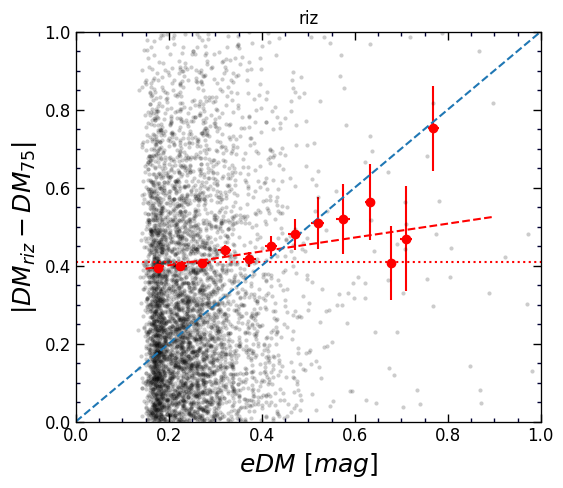

In [30]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = eDM_fid
Y = np.abs(DMav_fid - dff.DM_75.values)

V3k = dff.V3k.values
X = X[V3k>4000]
Y = Y[V3k>4000]

ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[Y<1]
Y = Y[Y<1]

factor = np.sqrt(np.pi/2.)
for i in np.arange(0.15,0.8,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        yp *= factor
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.std(yp)/np.sqrt(len(yp)), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)  
        
ax.set_ylabel(r'$|DM_{riz} - DM_{75}|$', fontsize=18)
ax.set_xlabel(r'$eDM \/\/ [mag]$', fontsize=18)

# ax.plot([0,1], [0,0], ':', color='k')

set_axes(ax, (0,1), (0,1), fontsize=12)

ax.set_title("riz")

from ltsfit.lts_linefit import lts_linefit
mcfit = lts_linefit(X, factor*Y, X*0+0.001, Y*0+0.001, clip=3., plot=False)
xx = np.linspace(0.15,0.9,100)
ax.plot(xx, mcfit.ab[1]*xx+mcfit.ab[0], '--', color='red')

yy0 = np.mean(factor*Y)
ax.plot([0,1],[yy0,yy0], ':', color='red')
ax.plot([0,1],[0,1], '--', color='#1f77b4')

<ipython-input-31-be545cefc1cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['dDM'] = DM_fid - dff.DM_75.values
<ipython-input-31-be545cefc1cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['DMriz_fid'] = DM_fid
<ipython-input-31-be545cefc1cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

Text(0.5, 1.0, '<riz>')

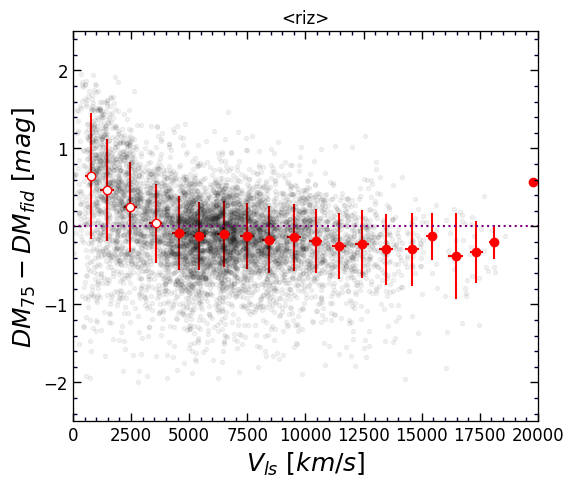

In [31]:
dff['dDM'] = DM_fid - dff.DM_75.values
dff['DMriz_fid'] = DM_fid
dff['DMav_riz'] = DMav_fid
dff['eDM_riz'] = eDM_fid
eDM_adj = mcfit.ab[1]*eDM_fid+mcfit.ab[0]
for jj in range(len(eDM_fid)):
    if eDM_fid[jj]>eDM_adj[jj]:
        eDM_adj[jj]=eDM_fid[jj]
dff['eDM_riz_adj'] = eDM_adj
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = dff.dDM.values
# logW = dff.lgWmxi.values

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   


for i in np.arange(0,4000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

ax.set_title("<riz>")

In [32]:
np.mean(Y[X>4000])

-0.17689310621767138

Text(0.5, 1.0, '<riz>')

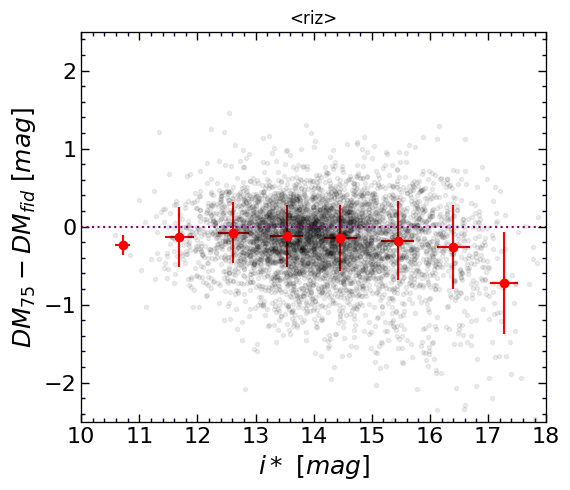

In [33]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


dff_ = dff[dff.V3k>4000]

X = dff_['i***'].values
Y = dff_.dDM.values
V = dff_.V3k.values

ax.plot(X, Y, 'k.', alpha=0.07)

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-2.5,2.5))

ax.set_title("<riz>")

In [34]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)))
dff['logMb'] = np.log10(dff.Mb.values)


dff[['DM_75', 'DMriz_fid', 'Mass_HI', 'Ms_riz', 'Mb', 'F21', 'eF21', 'Qs', 'DMav_riz', 'eDM_riz', 'eDM_riz_adj']].to_csv("MLratio_riz_distances_noCorrection.csv")

<ipython-input-34-e4da95568949>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-34-e4da95568949>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)))
<ipython-input-34-e4da95568949>:3: SettingWithCopy

<ipython-input-35-56dc55f5e058>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
<ipython-input-35-56dc55f5e058>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)+HI_corrector(mc, 0, dff.V3k.values)))
<ipython-input-35-56dc55f5e058>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

(3.1137439646812597, 10.425313763684564)

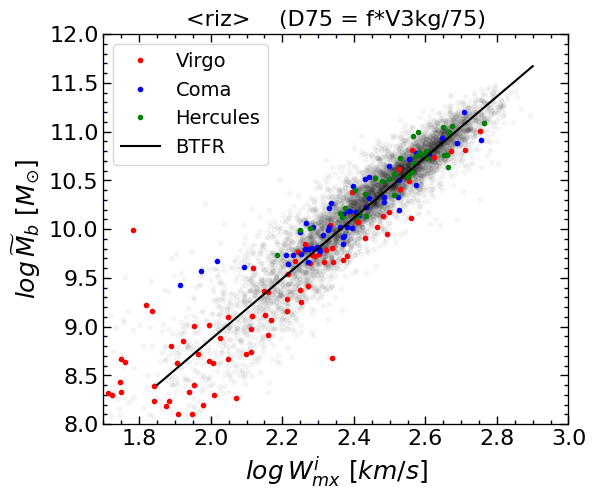

In [35]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)+HI_corrector(mc, 0, dff.V3k.values)))
dff['logMb'] = np.log10(dff.Mb.values)

######################################################################
dff = dff.rename(columns={"1PGC": "PGC1"})


df_vrigo = dff[dff.PGC1==41220]
df_coma = dff[dff.PGC1==44715]
df_herc = dff[dff.PGC1==56962]

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(logW, logMass, '.', color='black', alpha=0.03) 


ax.plot(df_vrigo.lgWmxi, df_vrigo.logMb, 'r.', label='Virgo')
ax.plot(df_coma.lgWmxi, df_coma.logMb, 'b.', label='Coma')
ax.plot(df_herc.lgWmxi, df_herc.logMb, 'g.', label='Hercules')

ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)

set_axes(ax, (1.7,3), (8,12))
ax.set_title("<riz>    (D75 = f*V3kg/75)", fontsize=16)

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, 'k-', label='BTFR')

ax.legend(fontsize=14, loc=2)   

m0, b0

In [36]:
len(dff)

7096

In [37]:
s = 1

dist = np.random.normal(-1, s, 1000000)

s/np.mean(np.abs(dist))

0.8572977356597725